## NDVI

Starting NDVI analysis (2015-2024 only)...
Analyzing NDVI files from 2015 to 2024
Looking in folder: /Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/LST to AT/Clipped

Total files found: 95
✓ 2015-01 (winter): NDVI = 0.031
✓ 2015-10 (fall): NDVI = 0.076
✓ 2015-12 (winter): NDVI = 0.036
✓ 2015-02 (winter): NDVI = 0.044
✓ 2015-03 (spring): NDVI = 0.039
✓ 2015-05 (spring): NDVI = 0.098
✓ 2015-06 (summer): NDVI = 0.117
✓ 2015-07 (summer): NDVI = 0.118
✓ 2015-09 (fall): NDVI = 0.096
✓ 2016-01 (winter): NDVI = 0.035
✓ 2016-10 (fall): NDVI = 0.098
✓ 2016-11 (fall): NDVI = 0.053
✓ 2016-12 (winter): NDVI = 0.035
✓ 2016-03 (spring): NDVI = 0.035
✓ 2016-04 (spring): NDVI = 0.039
✓ 2016-05 (spring): NDVI = 0.118
✓ 2016-07 (summer): NDVI = 0.121
✓ 2016-08 (summer): NDVI = 0.112
✓ 2016-09 (fall): NDVI = 0.097
✓ 2017-01 (winter): NDVI = 0.040
✓ 2017-10 (fall): NDVI = 0.073
✓ 2017-11 (fall): NDVI = 0.048
✓ 2017-12 (winter): NDVI = 0.041
✓ 2017-02 (winter): NDVI = 0.033
✓ 2017-03 (spring): 

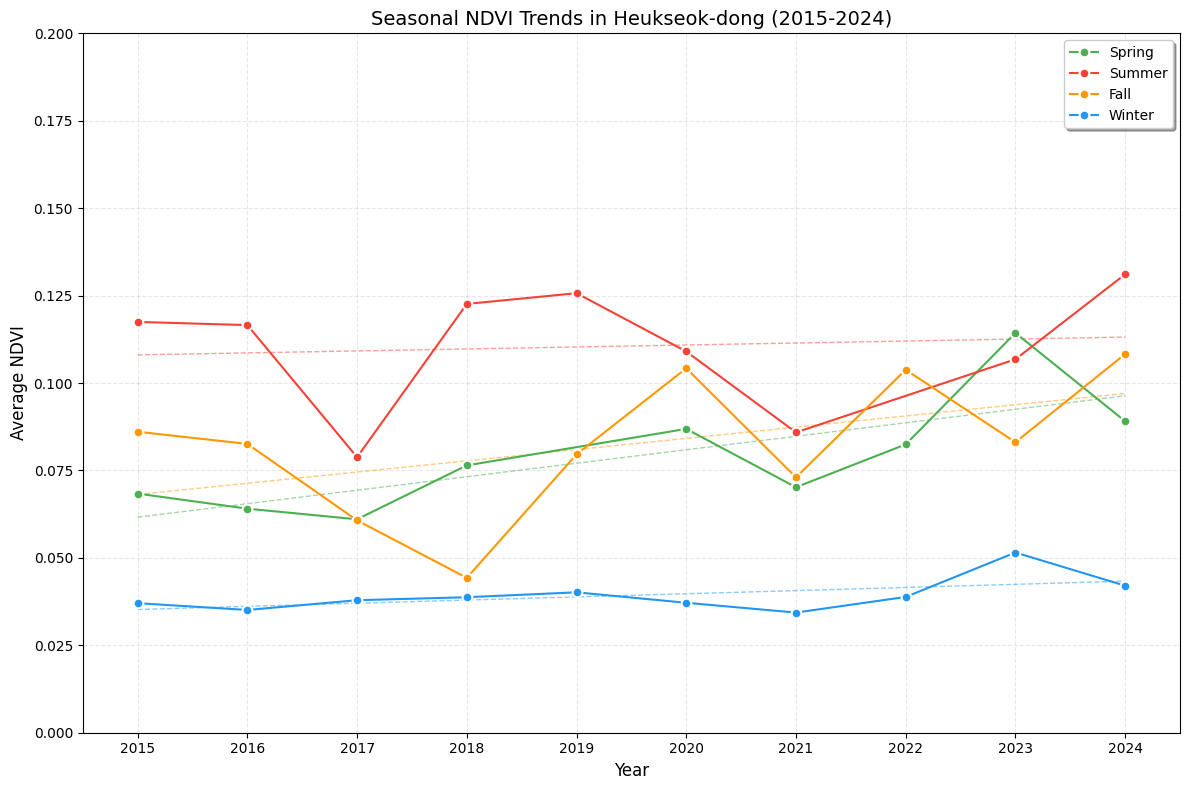


NDVI ANALYSIS SUMMARY (2015-2024)

Total months analyzed: 82
Years covered: 2015 - 2024

SEASONAL TRENDS:
----------------------------------------

SPRING:
  Period: 2015 → 2024
  NDVI: 0.068 → 0.089
  Change: +0.021 (+30.3%)
  Annual trend: +0.0039 per year
  Decade trend: +0.039 per decade

SUMMER:
  Period: 2015 → 2024
  NDVI: 0.117 → 0.131
  Change: +0.014 (+11.6%)
  Annual trend: +0.0006 per year
  Decade trend: +0.006 per decade

FALL:
  Period: 2015 → 2024
  NDVI: 0.086 → 0.108
  Change: +0.022 (+25.8%)
  Annual trend: +0.0032 per year
  Decade trend: +0.032 per decade

WINTER:
  Period: 2015 → 2024
  NDVI: 0.037 → 0.042
  Change: +0.005 (+13.5%)
  Annual trend: +0.0009 per year
  Decade trend: +0.009 per decade


DATA COMPLETENESS:
----------------------------------------
Expected months: 120
Available months: 82
Missing months: 38

Missing data for:
  - 2015-04
  - 2015-08
  - 2015-11
  - 2016-02
  - 2016-06
  - 2017-09
  - 2018-04
  - 2018-06
  - 2018-08
  - 2018-10
  ... an

In [45]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
import glob
from datetime import datetime

# ================================================
# NDVI SEASONAL ANALYSIS (2015-2024 ONLY)
# ================================================

def analyze_ndvi_folder(folder_path, start_year=2015, end_year=2024):
    """
    Analyze all NDVI rasters in folder for specified year range
    """
    print(f"Analyzing NDVI files from {start_year} to {end_year}")
    print(f"Looking in folder: {folder_path}")
    
    # Find all NDVI files
    pattern = os.path.join(folder_path, 'clipped_NDVI_*.tif')
    ndvi_files = glob.glob(pattern)
    print(f"\nTotal files found: {len(ndvi_files)}")
    
    # Process each file
    data = []
    skipped_files = []
    
    for file_path in sorted(ndvi_files):
        filename = os.path.basename(file_path)
        
        try:
            # Extract year and month from filename
            parts = filename.split('_')
            year = int(parts[2])
            month = int(parts[3].replace('.tif', ''))
            
            # Skip if outside year range
            if year < start_year or year > end_year:
                skipped_files.append((filename, year))
                continue
            
            # Determine season
            if month in [3, 4, 5]:
                season = 'spring'
            elif month in [6, 7, 8]:
                season = 'summer'
            elif month in [9, 10, 11]:
                season = 'fall'
            else:
                season = 'winter'
            
            # Read NDVI raster
            with rasterio.open(file_path) as src:
                ndvi = src.read(1)
                
                # Get valid pixels (not NaN and within NDVI range)
                valid_mask = (~np.isnan(ndvi)) & (ndvi >= -1) & (ndvi <= 1)
                
                if np.any(valid_mask):
                    mean_ndvi = np.mean(ndvi[valid_mask])
                    std_ndvi = np.std(ndvi[valid_mask])
                    pixel_count = np.sum(valid_mask)
                    
                    data.append({
                        'filename': filename,
                        'year': year,
                        'month': month,
                        'season': season,
                        'ndvi_mean': mean_ndvi,
                        'ndvi_std': std_ndvi,
                        'valid_pixels': pixel_count
                    })
                    
                    print(f"✓ {year}-{month:02d} ({season}): NDVI = {mean_ndvi:.3f}")
                else:
                    print(f"⚠ {year}-{month:02d}: No valid pixels")
                    
        except Exception as e:
            print(f"✗ Error processing {filename}: {e}")
    
    # Report skipped files
    if skipped_files:
        print(f"\nSkipped {len(skipped_files)} files outside {start_year}-{end_year}:")
        for fname, year in skipped_files[:5]:  # Show first 5
            print(f"  - {fname} (year: {year})")
        if len(skipped_files) > 5:
            print(f"  ... and {len(skipped_files) - 5} more")
    
    return pd.DataFrame(data)

def create_seasonal_plot(df, save_path='ndvi_seasonal_2015_2024.png'):
    """
    Create the seasonal NDVI trend plot
    """
    # Calculate seasonal averages
    seasonal_avg = df.groupby(['year', 'season']).agg({
        'ndvi_mean': ['mean', 'std', 'count']
    }).reset_index()
    seasonal_avg.columns = ['year', 'season', 'ndvi_avg', 'ndvi_std', 'count']
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Colors and markers for seasons
    season_styles = {
        'spring': {'color': '#4CAF50', 'marker': 'o', 'label': 'Spring'},
        'summer': {'color': '#F44336', 'marker': 'o', 'label': 'Summer'},
        'fall': {'color': '#FF9800', 'marker': 'o', 'label': 'Fall'},
        'winter': {'color': '#2196F3', 'marker': 'o', 'label': 'Winter'}
    }
    
    # Plot each season
    for season, style in season_styles.items():
        season_data = seasonal_avg[seasonal_avg['season'] == season].sort_values('year')
        
        if len(season_data) > 0:
            # Main line
            ax.plot(season_data['year'], season_data['ndvi_avg'],
                   color=style['color'],
                   marker=style['marker'],
                   markersize=7,
                   linewidth=1.5,
                   label=style['label'],
                   markeredgecolor='white',
                   markeredgewidth=1.5,
                   zorder=3)
            
            # Add trend line
            if len(season_data) > 2:
                z = np.polyfit(season_data['year'], season_data['ndvi_avg'], 1)
                p = np.poly1d(z)
                ax.plot(season_data['year'], p(season_data['year']),
                       color=style['color'],
                       linestyle='--',
                       alpha=0.5,
                       linewidth=1,
                       zorder=2)
    
    # Customize plot
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Average NDVI', fontsize=12)
    ax.set_title('Seasonal NDVI Trends in Heukseok-dong (2015-2024)', 
                fontsize=14)
    
    # Set axis limits
    ax.set_xlim(2014.5, 2024.5)
    ax.set_ylim(0, 0.2)
    
    # Set x-ticks
    ax.set_xticks(range(2015, 2025))
    
    # Add grid
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Legend
    ax.legend(loc='best', frameon=True, fancybox=True, shadow=True)
    
    # Save figure
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return seasonal_avg

def generate_summary_report(df):
    """
    Generate summary statistics and trends
    """
    print("\n" + "="*60)
    print("NDVI ANALYSIS SUMMARY (2015-2024)")
    print("="*60)
    
    # Overall statistics
    print(f"\nTotal months analyzed: {len(df)}")
    print(f"Years covered: {df['year'].min()} - {df['year'].max()}")
    
    # Seasonal averages
    seasonal_avg = df.groupby(['year', 'season'])['ndvi_mean'].mean().reset_index()
    
    print("\nSEASONAL TRENDS:")
    print("-" * 40)
    
    for season in ['spring', 'summer', 'fall', 'winter']:
        season_data = seasonal_avg[seasonal_avg['season'] == season].sort_values('year')
        
        if len(season_data) >= 2:
            # Calculate trend
            years = season_data['year'].values
            ndvi_values = season_data['ndvi_mean'].values
            
            # Linear regression
            slope, intercept = np.polyfit(years, ndvi_values, 1)
            
            # Get first and last values
            first_year = season_data['year'].iloc[0]
            last_year = season_data['year'].iloc[-1]
            first_val = season_data['ndvi_mean'].iloc[0]
            last_val = season_data['ndvi_mean'].iloc[-1]
            
            # Calculate changes
            total_change = last_val - first_val
            pct_change = (total_change / first_val) * 100
            
            print(f"\n{season.upper()}:")
            print(f"  Period: {first_year} → {last_year}")
            print(f"  NDVI: {first_val:.3f} → {last_val:.3f}")
            print(f"  Change: {total_change:+.3f} ({pct_change:+.1f}%)")
            print(f"  Annual trend: {slope:+.4f} per year")
            print(f"  Decade trend: {slope*10:+.3f} per decade")
    
    # Missing months analysis
    print("\n\nDATA COMPLETENESS:")
    print("-" * 40)
    
    # Expected months
    expected_months = []
    for year in range(2015, 2025):
        for month in range(1, 13):
            expected_months.append((year, month))
    
    # Actual months
    actual_months = set(zip(df['year'], df['month']))
    missing_months = set(expected_months) - actual_months
    
    print(f"Expected months: {len(expected_months)}")
    print(f"Available months: {len(actual_months)}")
    print(f"Missing months: {len(missing_months)}")
    
    if missing_months:
        print("\nMissing data for:")
        for year, month in sorted(missing_months)[:10]:
            print(f"  - {year}-{month:02d}")
        if len(missing_months) > 10:
            print(f"  ... and {len(missing_months) - 10} more")

# ================================================
# MAIN EXECUTION
# ================================================

if __name__ == "__main__":
    # SET YOUR FOLDER PATH HERE!
    NDVI_FOLDER = '/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/LST to AT/Clipped'
    
    # Run analysis
    print("Starting NDVI analysis (2015-2024 only)...")
    
    # Check if folder exists
    if not os.path.exists(NDVI_FOLDER):
        print(f"\nERROR: Folder not found: {NDVI_FOLDER}")
        print("Please update the NDVI_FOLDER path and try again.")
    else:
        # Analyze NDVI files
        df = analyze_ndvi_folder(NDVI_FOLDER, start_year=2015, end_year=2024)
        
        if len(df) > 0:
            # Create plot
            seasonal_data = create_seasonal_plot(df)
            
            # Generate report
            generate_summary_report(df)
            
            # Save data
            df.to_csv('ndvi_monthly_2015_2024.csv', index=False)
            seasonal_data.to_csv('ndvi_seasonal_2015_2024.csv', index=False)
            
            print("\n\n✓ ANALYSIS COMPLETE!")
            print("Files saved:")
            print("  - ndvi_seasonal_2015_2024.png (plot)")
            print("  - ndvi_monthly_2015_2024.csv (monthly data)")
            print("  - ndvi_seasonal_2015_2024.csv (seasonal averages)")
        else:
            print("\nNo valid NDVI data found for 2015-2024.")

## Air Temperature

Starting Air Temperature analysis (2015-2024 only)...
Analyzing Air Temperature files from 2015 to 2024
Looking in folder: /Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/LST to AT/Clipped

Total files found: 95

Skipped 13 files outside 2015-2024:
  - clipped_AirTemp_2013_12.tif (year: 2013)
  - clipped_AirTemp_2013_5.tif (year: 2013)
  - clipped_AirTemp_2013_6.tif (year: 2013)
  - clipped_AirTemp_2013_9.tif (year: 2013)
  - clipped_AirTemp_2014_1.tif (year: 2014)
  ... and 8 more


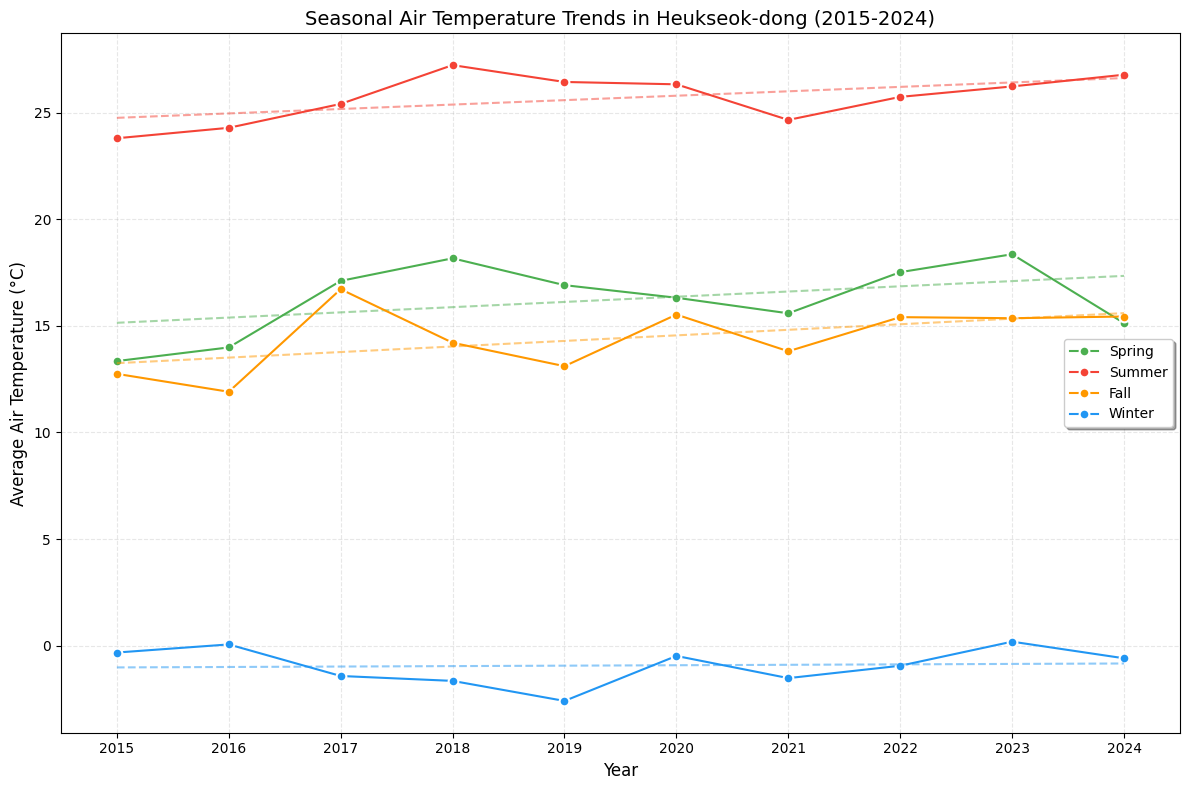


CORRECTED SEASONAL AIR TEMPERATURE TRENDS (2015-2024)

SPRING:
  2015: 13.35°C
  2024: 15.13°C
  Change: +1.78°C
  Trend: +2.44°C per decade
  Status: Warming

SUMMER:
  2015: 23.80°C
  2024: 26.78°C
  Change: +2.98°C
  Trend: +2.07°C per decade
  Status: Warming

FALL:
  2015: 12.75°C
  2024: 15.44°C
  Change: +2.69°C
  Trend: +2.61°C per decade
  Status: Warming

WINTER:
  2015: -0.32°C
  2024: -0.59°C
  Change: -0.27°C
  Trend: +0.20°C per decade
  Status: Cooling

✓ ANALYSIS COMPLETE!
Files saved:
  - Air_Temperature_seasonal_2015_2024.png (plot)
  - Air_Temperature_monthly_2015_2024.csv (monthly data)
  - Air_Temperature_seasonal_2015_2024.csv (seasonal averages)


In [47]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
import glob
from datetime import datetime

# ================================================
# Air Temperature SEASONAL ANALYSIS (2015-2024 ONLY)
# ================================================

def analyze_AT_folder(folder_path, start_year=2015, end_year=2024):
    """
    Analyze all Air Temperature rasters in folder for specified year range
    """
    print(f"Analyzing Air Temperature files from {start_year} to {end_year}")
    print(f"Looking in folder: {folder_path}")
    
    # Find all Air Temperature files
    pattern = os.path.join(folder_path, 'clipped_AirTemp_*.tif')
    AT_files = glob.glob(pattern)
    print(f"\nTotal files found: {len(AT_files)}")
    
    # Process each file
    data = []
    skipped_files = []
    
    for file_path in sorted(AT_files):
        filename = os.path.basename(file_path)
        
        try:
            # Extract year and month from filename
            parts = filename.split('_')
            year = int(parts[2])
            month = int(parts[3].replace('.tif', ''))
            
            # Skip if outside year range
            if year < start_year or year > end_year:
                skipped_files.append((filename, year))
                continue
            
            # Determine season
            if month in [3, 4, 5]:
                season = 'spring'
            elif month in [6, 7, 8]:
                season = 'summer'
            elif month in [9, 10, 11]:
                season = 'fall'
            else:
                season = 'winter'
            
            # Read Air Temperature raster
            with rasterio.open(file_path) as src:
                AT = src.read(1)
                
                # Get valid pixels (not NaN and within Air Temperature range)
                valid_mask = (~np.isnan(AT)) & (AT >= -20) & (AT <= 40)
                
                if np.any(valid_mask):
                    mean_AT = np.mean(AT[valid_mask])
                    std_AT = np.std(AT[valid_mask])
                    pixel_count = np.sum(valid_mask)
                    
                    data.append({
                        'filename': filename,
                        'year': year,
                        'month': month,
                        'season': season,
                        'AT_mean': mean_AT,
                        'AT_std': std_AT,
                        'valid_pixels': pixel_count
                    })
                    
        except Exception as e:
            print(f"✗ Error processing {filename}: {e}")
    
    # Report skipped files
    if skipped_files:
        print(f"\nSkipped {len(skipped_files)} files outside {start_year}-{end_year}:")
        for fname, year in skipped_files[:5]:  # Show first 5
            print(f"  - {fname} (year: {year})")
        if len(skipped_files) > 5:
            print(f"  ... and {len(skipped_files) - 5} more")
    
    return pd.DataFrame(data)

def create_seasonal_plot(df, save_path='AirTemp_seasonal_2015_2024.png'):
    """
    Create the seasonal Air Temperature trend plot
    """
    # Calculate seasonal averages
    seasonal_avg = df.groupby(['year', 'season']).agg({
        'AT_mean': ['mean', 'std', 'count']
    }).reset_index()
    seasonal_avg.columns = ['year', 'season', 'AT_avg', 'AT_std', 'count']
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Colors and markers for seasons
    season_styles = {
        'spring': {'color': '#4CAF50', 'marker': 'o', 'label': 'Spring'},
        'summer': {'color': '#F44336', 'marker': 'o', 'label': 'Summer'},
        'fall': {'color': '#FF9800', 'marker': 'o', 'label': 'Fall'},
        'winter': {'color': '#2196F3', 'marker': 'o', 'label': 'Winter'}
    }
    
    # Plot each season
    for season, style in season_styles.items():
        season_data = seasonal_avg[seasonal_avg['season'] == season].sort_values('year')
        
        if len(season_data) > 0:
            # Main line
            ax.plot(season_data['year'], season_data['AT_avg'],
                   color=style['color'],
                   marker=style['marker'],
                   markersize=7,
                   linewidth=1.5,
                   label=style['label'],
                   markeredgecolor='white',
                   markeredgewidth=1.5,
                   zorder=3)
            
            # Add trend line
            if len(season_data) > 2:
                z = np.polyfit(season_data['year'], season_data['AT_avg'], 1)
                p = np.poly1d(z)
                ax.plot(season_data['year'], p(season_data['year']),
                       color=style['color'],
                       linestyle='--',
                       alpha=0.5,
                       linewidth=1,
                       zorder=2)
    
    # Customize plot
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Average Air Temperature (°C)', fontsize=12)
    ax.set_title('Seasonal Air Temperature Trends in Heukseok-dong (2015-2024)', 
                fontsize=14)
    
    # Set axis limits
    ax.set_xlim(2014.5, 2024.5)
    ax.set_ylim(-5, 30)
    
    # Set x-ticks
    ax.set_xticks(range(2015, 2025))
    
    # Add grid
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Legend
    ax.legend(loc='best', frameon=True, fancybox=True, shadow=True)
    
    # Save figure
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return seasonal_avg

def generate_summary_report(df):
    """
    Generate summary statistics and trends
    """
    print("\n" + "="*60)
    print("Air Temperature ANALYSIS SUMMARY (2015-2024)")
    print("="*60)
    
    # Overall statistics
    print(f"\nTotal months analyzed: {len(df)}")
    print(f"Years covered: {df['year'].min()} - {df['year'].max()}")
    
    # Seasonal averages
    seasonal_avg = df.groupby(['year', 'season'])['AT_mean'].mean().reset_index()
    
    print("\nSEASONAL TRENDS:")
    print("-" * 40)
    
    for season in ['spring', 'summer', 'fall', 'winter']:
        season_data = seasonal_avg[seasonal_avg['season'] == season].sort_values('year')
        
        if len(season_data) >= 2:
            # Calculate trend
            years = season_data['year'].values
            AT_values = season_data['AT_mean'].values
            
            # Linear regression
            slope, intercept = np.polyfit(years, AT_values, 1)
            
            # Get first and last values
            first_year = season_data['year'].iloc[0]
            last_year = season_data['year'].iloc[-1]
            first_val = season_data['AT_mean'].iloc[0]
            last_val = season_data['AT_mean'].iloc[-1]
            
            # Calculate changes
            total_change = last_val - first_val
            pct_change = (total_change / first_val) * 100
            
            print(f"\n{season.upper()}:")
            print(f"  Period: {first_year} → {last_year}")
            print(f"  Air Temperature: {first_val:.3f} → {last_val:.3f}")
            print(f"  Change: {total_change:+.3f} ({pct_change:+.1f}%)")
            print(f"  Annual trend: {slope:+.4f} per year")
            print(f"  Decade trend: {slope*10:+.3f} per decade")
    
    # Missing months analysis
    print("\n\nDATA COMPLETENESS:")
    print("-" * 40)
    
    # Expected months
    expected_months = []
    for year in range(2015, 2025):
        for month in range(1, 13):
            expected_months.append((year, month))
    
    # Actual months
    actual_months = set(zip(df['year'], df['month']))
    missing_months = set(expected_months) - actual_months
    
    print(f"Expected months: {len(expected_months)}")
    print(f"Available months: {len(actual_months)}")
    print(f"Missing months: {len(missing_months)}")
    
    if missing_months:
        print("\nMissing data for:")
        for year, month in sorted(missing_months)[:10]:
            print(f"  - {year}-{month:02d}")
        if len(missing_months) > 10:
            print(f"  ... and {len(missing_months) - 10} more")

# ================================================
# MAIN EXECUTION
# ================================================

if __name__ == "__main__":
    # SET YOUR FOLDER PATH HERE!
    AT_FOLDER = '/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/LST to AT/Clipped'  # <-- CHANGE THIS!
    
    # Run analysis
    print("Starting Air Temperature analysis (2015-2024 only)...")
    
    # Check if folder exists
    if not os.path.exists(AT_FOLDER):
        print(f"\nERROR: Folder not found: {AT_FOLDER}")
        print("Please update the AT_FOLDER path and try again.")
    else:
        # Analyze Air Temperature files
        df = analyze_AT_folder(AT_FOLDER, start_year=2015, end_year=2024)
        
        if len(df) > 0:
            # Create plot
            seasonal_data = create_seasonal_plot(df)
            
            # Generate report
            generate_summary_report(df)
            
            # Save data
            df.to_csv('Air Temperature_monthly_2015_2024.csv', index=False)
            seasonal_data.to_csv('Air Temperature_seasonal_2015_2024.csv', index=False)
            
            print("\n\n✓ ANALYSIS COMPLETE!")
            print("Files saved:")
            print("  - Air_Temperature_seasonal_2015_2024.png (plot)")
            print("  - Air_Temperature_monthly_2015_2024.csv (monthly data)")
            print("  - Air_Temperature_seasonal_2015_2024.csv (seasonal averages)")
        else:
            print("\nNo valid Air Temperature data found for 2015-2024.")
            


## Building Volume

Found 10 shapefiles

Processing Shapefile_2015.shp...
  ✓ Year 2015: 3399 buildings
    Average volume: 2,161 m³
    Total volume: 7,346,816 m³

Processing Shapefile_2016.shp...
  ✓ Year 2016: 3399 buildings
    Average volume: 2,161 m³
    Total volume: 7,346,816 m³

Processing Shapefile_2017.shp...
  ✓ Year 2017: 2862 buildings
    Average volume: 2,410 m³
    Total volume: 6,896,401 m³

Processing Shapefile_2018.shp...
  ✓ Year 2018: 2865 buildings
    Average volume: 2,391 m³
    Total volume: 6,850,219 m³

Processing Shapefile_2019.shp...
  ✓ Year 2019: 2387 buildings
    Average volume: 2,889 m³
    Total volume: 6,897,079 m³

Processing Shapefile_2020.shp...
  ✓ Year 2020: 2372 buildings
    Average volume: 2,893 m³
    Total volume: 6,862,571 m³

Processing Shapefile_2021.shp...
  ✓ Year 2021: 2356 buildings
    Average volume: 2,913 m³
    Total volume: 6,864,170 m³

Processing Shapefile_2022.shp...
  ✓ Year 2022: 2370 buildings
    Average volume: 3,201 m³
    Total volume: 7

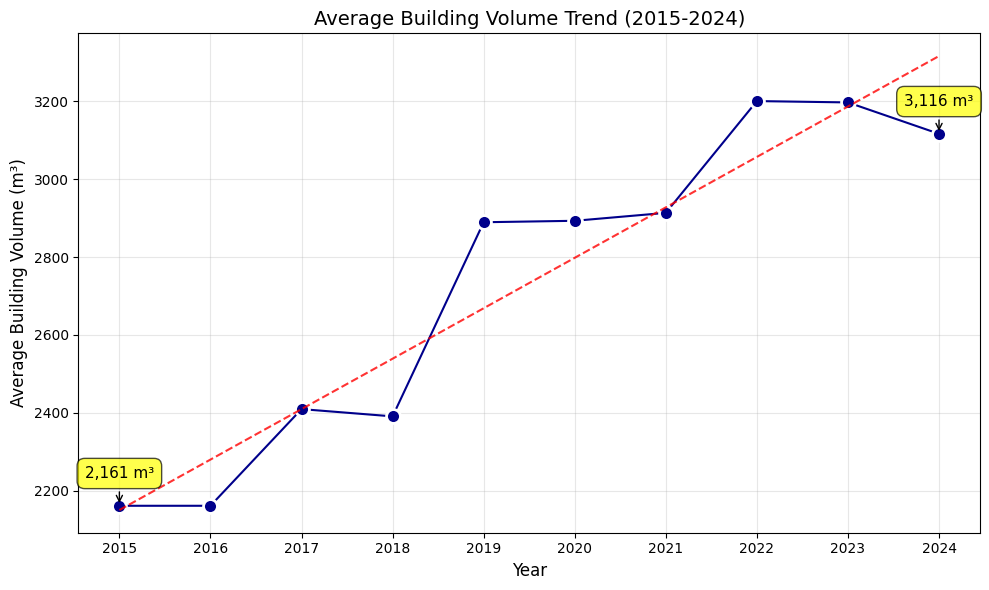


BUILDING VOLUME ANALYSIS SUMMARY (2015-2024)

Years analyzed: 2015 - 2024
Number of years: 10

AVERAGE BUILDING VOLUME:
  2015: 2,161 m³
  2024: 3,116 m³
  Total change: +955 m³ (+44.2%)
  Annual change: +106 m³/year

TOTAL BUILDINGS:
  2015: 3,399
  2024: 2,433
  Change: -966 buildings

TOTAL BUILDING VOLUME:
  2015: 7,346,816 m³
  2024: 7,582,309 m³
  Change: +235,492 m³

YEAR-BY-YEAR DETAILS:
------------------------------------------------------------
Year   Buildings  Avg Volume      Total Volume        
------------------------------------------------------------
2015.0 3,399.0    2,161           7,346,816           
2016.0 3,399.0    2,161           7,346,816           
2017.0 2,862.0    2,410           6,896,401           
2018.0 2,865.0    2,391           6,850,219           
2019.0 2,387.0    2,889           6,897,079           
2020.0 2,372.0    2,893           6,862,571           
2021.0 2,356.0    2,913           6,864,170           
2022.0 2,370.0    3,201           7,58

In [5]:
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob

# ================================================
# BUILDING VOLUME CHANGE ANALYSIS (2015-2024)
# ================================================

# 1. SET YOUR FOLDER PATH HERE!
SHAPEFILE_FOLDER = '/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Final shapefile'  # <-- CHANGE THIS!

# 2. Find all shapefiles
shapefile_pattern = os.path.join(SHAPEFILE_FOLDER, 'Shapefile_*.shp')
shapefiles = glob.glob(shapefile_pattern)
print(f"Found {len(shapefiles)} shapefiles")

# 3. Process each shapefile
volume_data = []

for shapefile in sorted(shapefiles):
    filename = os.path.basename(shapefile)
    
    try:
        # Extract year from filename (Shapefile_2024.shp)
        year = int(filename.split('_')[1].split('.')[0])
        
        # Skip if not in 2015-2024 range
        if year < 2015 or year > 2024:
            print(f"⏭ Skipping {filename} (year {year} outside range)")
            continue
        
        # Read shapefile
        print(f"\nProcessing {filename}...")
        gdf = gpd.read_file(shapefile)
        
        # Check if volume column exists (handle different variations)
        volume_col = None
        possible_cols = ['Volume (m3', 'Volume (m3)', 'volume', 'VOLUME', 'Volume']
        
        for col in possible_cols:
            if col in gdf.columns:
                volume_col = col
                break
        
        if volume_col is None:
            print(f"  ⚠ No volume column found. Available columns: {list(gdf.columns)}")
            continue
        
        # Get volume data
        volumes = gdf[volume_col].dropna()
        
        # Calculate statistics
        total_buildings = len(gdf)
        buildings_with_volume = len(volumes)
        avg_volume = volumes.mean()
        median_volume = volumes.median()
        total_volume = volumes.sum()
        std_volume = volumes.std()
        min_volume = volumes.min()
        max_volume = volumes.max()
        
        # Store results
        volume_data.append({
            'year': year,
            'total_buildings': total_buildings,
            'buildings_with_volume': buildings_with_volume,
            'avg_volume': avg_volume,
            'median_volume': median_volume,
            'total_volume': total_volume,
            'std_volume': std_volume,
            'min_volume': min_volume,
            'max_volume': max_volume
        })
        
        print(f"  ✓ Year {year}: {buildings_with_volume} buildings")
        print(f"    Average volume: {avg_volume:,.0f} m³")
        print(f"    Total volume: {total_volume:,.0f} m³")
        
    except Exception as e:
        print(f"✗ Error processing {filename}: {e}")

# 4. Create DataFrame
df = pd.DataFrame(volume_data)
df = df.sort_values('year')

# 5. Create visualizations
if len(df) > 0:
    plt.figure(figsize=(10, 6))
    plt.plot(df['year'], df['avg_volume'], color='darkblue', marker='o', 
             markersize=10, linewidth=1.5, markeredgecolor='white', markeredgewidth=2)
    
    # Add trend line
    if len(df) > 1:
        z = np.polyfit(df['year'], df['avg_volume'], 1)
        p = np.poly1d(z)
        plt.plot(df['year'], p(df['year']), "r--", alpha=0.8, linewidth=1.5, label='Trend')
    
    plt.xlabel('Year', fontsize=12, fontweight='light')
    plt.ylabel('Average Building Volume (m³)', fontsize=12)
    plt.title('Average Building Volume Trend (2015-2024)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.xticks(range(2015, 2025))
    
    # Add annotations for first and last year
    for i in [0, -1]:
        plt.annotate(f'{df["avg_volume"].iloc[i]:,.0f} m³',
                    xy=(df['year'].iloc[i], df['avg_volume'].iloc[i]),
                    xytext=(0, 20),
                    textcoords='offset points',
                    ha='center',
                    fontsize=11,
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    plt.tight_layout()
    plt.savefig('building_volume_trend_simple.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 7. Print summary statistics
    print("\n" + "="*60)
    print("BUILDING VOLUME ANALYSIS SUMMARY (2015-2024)")
    print("="*60)
    
    print(f"\nYears analyzed: {df['year'].min()} - {df['year'].max()}")
    print(f"Number of years: {len(df)}")
    
    # Overall changes
    start_avg = df['avg_volume'].iloc[0]
    end_avg = df['avg_volume'].iloc[-1]
    total_change = end_avg - start_avg
    pct_change = (total_change / start_avg) * 100
    
    print(f"\nAVERAGE BUILDING VOLUME:")
    print(f"  {df['year'].iloc[0]}: {start_avg:,.0f} m³")
    print(f"  {df['year'].iloc[-1]}: {end_avg:,.0f} m³")
    print(f"  Total change: {total_change:+,.0f} m³ ({pct_change:+.1f}%)")
    print(f"  Annual change: {total_change/(df['year'].iloc[-1]-df['year'].iloc[0]):+,.0f} m³/year")
    
    # Building count changes
    start_count = df['total_buildings'].iloc[0]
    end_count = df['total_buildings'].iloc[-1]
    count_change = end_count - start_count
    
    print(f"\nTOTAL BUILDINGS:")
    print(f"  {df['year'].iloc[0]}: {start_count:,}")
    print(f"  {df['year'].iloc[-1]}: {end_count:,}")
    print(f"  Change: {count_change:+,} buildings")
    
    # Total volume changes
    start_total = df['total_volume'].iloc[0]
    end_total = df['total_volume'].iloc[-1]
    total_vol_change = end_total - start_total
    
    print(f"\nTOTAL BUILDING VOLUME:")
    print(f"  {df['year'].iloc[0]}: {start_total:,.0f} m³")
    print(f"  {df['year'].iloc[-1]}: {end_total:,.0f} m³")
    print(f"  Change: {total_vol_change:+,.0f} m³")
    
    # Year-by-year details
    print(f"\nYEAR-BY-YEAR DETAILS:")
    print("-" * 60)
    print(f"{'Year':<6} {'Buildings':<10} {'Avg Volume':<15} {'Total Volume':<20}")
    print("-" * 60)
    for _, row in df.iterrows():
        print(f"{row['year']:<6} {row['total_buildings']:<10,} "
              f"{row['avg_volume']:<15,.0f} {row['total_volume']:<20,.0f}")
    
    # 8. Save results
    df.to_csv('building_volume_analysis.csv', index=False)
    print(f"\n✓ Results saved to 'building_volume_analysis.csv'")
    
else:
    print("\nNo valid data found for analysis.")

Found 10 shapefiles
Processing Shapefile_2015.shp...
  ✓ Year 2015: 3,399 buildings
Processing Shapefile_2016.shp...
  ✓ Year 2016: 3,399 buildings
Processing Shapefile_2017.shp...
  ✓ Year 2017: 2,862 buildings
Processing Shapefile_2018.shp...
  ✓ Year 2018: 2,865 buildings
Processing Shapefile_2019.shp...
  ✓ Year 2019: 2,387 buildings
Processing Shapefile_2020.shp...
  ✓ Year 2020: 2,372 buildings
Processing Shapefile_2021.shp...
  ✓ Year 2021: 2,356 buildings
Processing Shapefile_2022.shp...
  ✓ Year 2022: 2,370 buildings
Processing Shapefile_2023.shp...
  ✓ Year 2023: 2,371 buildings
Processing Shapefile_2024.shp...
  ✓ Year 2024: 2,433 buildings


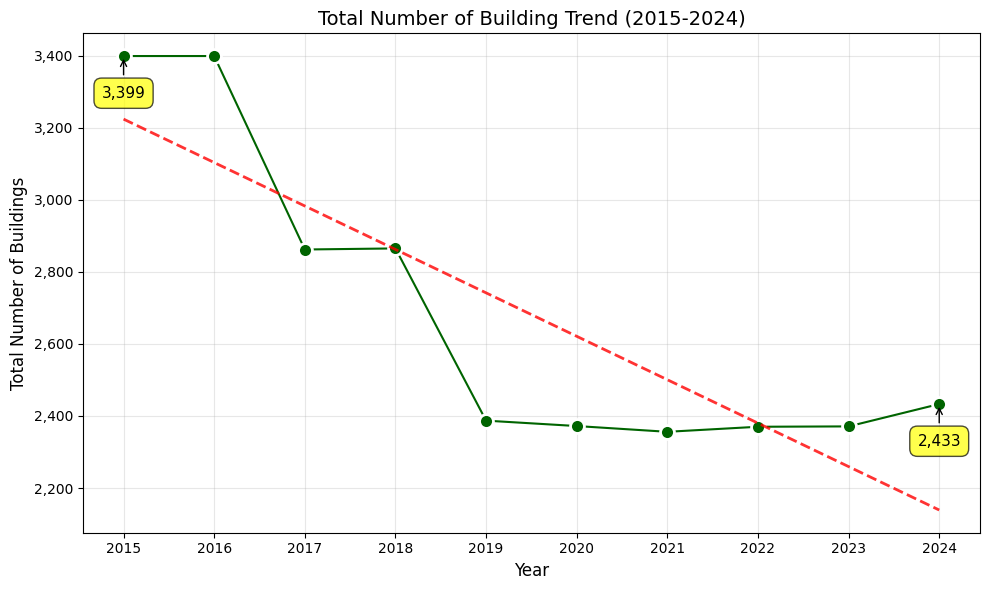


BUILDING COUNT ANALYSIS SUMMARY (2015-2024)

Total buildings in 2015: 3,399
Total buildings in 2024: 2,433
Change: -966 buildings (-28.4%)
Average annual change: -107 buildings/year

YEAR-BY-YEAR DETAILS:
------------------------------
Year       Buildings       Change         
------------------------------
2015       3,399           -
2016       3,399           +0
2017       2,862           -537
2018       2,865           +3
2019       2,387           -478
2020       2,372           -15
2021       2,356           -16
2022       2,370           +14
2023       2,371           +1
2024       2,433           +62

✓ Results saved to 'building_count_analysis.csv'


In [80]:
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob

# ================================================
# BUILDING COUNT TREND ANALYSIS (2015-2024)
# ================================================

# 1. SET YOUR FOLDER PATH HERE!
SHAPEFILE_FOLDER = '/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Final shapefile'  # <-- CHANGE THIS!

# 2. Find all shapefiles
shapefile_pattern = os.path.join(SHAPEFILE_FOLDER, 'Shapefile_*.shp')
shapefiles = glob.glob(shapefile_pattern)
print(f"Found {len(shapefiles)} shapefiles")

# 3. Process each shapefile
building_count_data = []

for shapefile in sorted(shapefiles):
    filename = os.path.basename(shapefile)
    
    try:
        # Extract year from filename (Shapefile_2024.shp)
        year = int(filename.split('_')[1].split('.')[0])
        
        # Skip if not in 2015-2024 range
        if year < 2015 or year > 2024:
            print(f"⏭ Skipping {filename} (year {year} outside range)")
            continue
        
        # Read shapefile
        print(f"Processing {filename}...")
        gdf = gpd.read_file(shapefile)
        
        # Count buildings
        total_buildings = len(gdf)
        
        # Store results
        building_count_data.append({
            'year': year,
            'total_buildings': total_buildings
        })
        
        print(f"  ✓ Year {year}: {total_buildings:,} buildings")
        
    except Exception as e:
        print(f"✗ Error processing {filename}: {e}")

# 4. Create DataFrame and sort by year
df = pd.DataFrame(building_count_data)
df = df.sort_values('year')

# 5. Create the building count trend plot (same style as volume trend)
if len(df) > 0:
    plt.figure(figsize=(10, 6))
    
    # Main line plot
    plt.plot(df['year'], df['total_buildings'], 
             color='darkgreen', 
             marker='o', 
             markersize=10, 
             linewidth=1.5, 
             markeredgecolor='white', 
             markeredgewidth=2)
    
    # Add trend line
    if len(df) > 1:
        z = np.polyfit(df['year'], df['total_buildings'], 1)
        p = np.poly1d(z)
        plt.plot(df['year'], p(df['year']), "r--", alpha=0.8, linewidth=2, label='Trend')
    
    # Labels and title
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Total Number of Buildings', fontsize=12)
    plt.title('Total Number of Building Trend (2015-2024)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.xticks(range(2015, 2025))
    
    # Format y-axis to show thousands separator
    ax = plt.gca()
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
    
    # Add annotations for first and last year
    for i in [0, -1]:
        plt.annotate(f'{df["total_buildings"].iloc[i]:,}',
                    xy=(df['year'].iloc[i], df['total_buildings'].iloc[i]),
                    xytext=(0, -30),
                    textcoords='offset points',
                    ha='center',
                    fontsize=11,
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    plt.tight_layout()
    plt.savefig('building_count_trend.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 6. Print summary
    print("\n" + "="*60)
    print("BUILDING COUNT ANALYSIS SUMMARY (2015-2024)")
    print("="*60)
    
    print(f"\nTotal buildings in {df['year'].iloc[0]}: {start_count:,}")
    print(f"Total buildings in {df['year'].iloc[-1]}: {end_count:,}")
    print(f"Change: {total_change:+,} buildings ({pct_change:+.1f}%)")
    print(f"Average annual change: {total_change/(df['year'].iloc[-1]-df['year'].iloc[0]):+,.0f} buildings/year")
    
    # Year-by-year details
    print(f"\nYEAR-BY-YEAR DETAILS:")
    print("-" * 30)
    print(f"{'Year':<10} {'Buildings':<15} {'Change':<15}")
    print("-" * 30)
    
    for i, row in df.iterrows():
        if i > 0:
            prev_count = df['total_buildings'].iloc[list(df.index).index(i)-1]
            change = row['total_buildings'] - prev_count
            print(f"{row['year']:<10} {row['total_buildings']:<15,} {change:+,}")
        else:
            print(f"{row['year']:<10} {row['total_buildings']:<15,} -")
    
    # 7. Save results
    df.to_csv('building_count_analysis.csv', index=False)
    print(f"\n✓ Results saved to 'building_count_analysis.csv'")
    
else:
    print("\nNo valid data found for analysis.")

## Building Height

Found 10 shapefiles

Processing Shapefile_2015.shp...
  ✓ Year 2015: 3399 buildings
    Average height: 8.9 m

Processing Shapefile_2016.shp...
  ✓ Year 2016: 3399 buildings
    Average height: 8.9 m

Processing Shapefile_2017.shp...
  ✓ Year 2017: 2862 buildings
    Average height: 8.8 m

Processing Shapefile_2018.shp...
  ✓ Year 2018: 2865 buildings
    Average height: 8.9 m

Processing Shapefile_2019.shp...
  ✓ Year 2019: 2387 buildings
    Average height: 9.0 m

Processing Shapefile_2020.shp...
  ✓ Year 2020: 2372 buildings
    Average height: 8.9 m

Processing Shapefile_2021.shp...
  ✓ Year 2021: 2356 buildings
    Average height: 9.0 m

Processing Shapefile_2022.shp...
  ✓ Year 2022: 2370 buildings
    Average height: 9.4 m

Processing Shapefile_2023.shp...
  ✓ Year 2023: 2371 buildings
    Average height: 9.4 m

Processing Shapefile_2024.shp...
  ✓ Year 2024: 2433 buildings
    Average height: 9.3 m


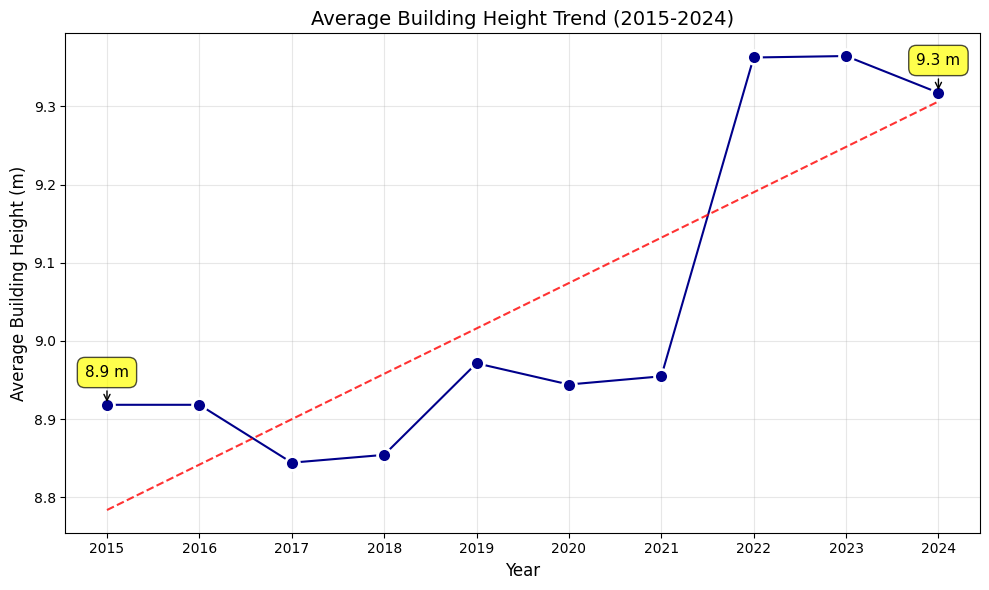


BUILDING HEIGHT ANALYSIS SUMMARY (2015-2024)

Average height in 2015: 8.9 m
Average height in 2024: 9.3 m
Change: +0.4 m (+4.5%)
Average annual change: +0.04 m/year

In terms of floors (assuming 3m/floor):
  2015: 3.0 floors
  2024: 3.1 floors
  Change: +0.1 floors

YEAR-BY-YEAR DETAILS:
--------------------------------------------------
Year       Avg Height (m)  Avg Floors      Buildings      
--------------------------------------------------
2015.0     8.9             3.0             3,399.0        
2016.0     8.9             3.0             3,399.0        
2017.0     8.8             2.9             2,862.0        
2018.0     8.9             3.0             2,865.0        
2019.0     9.0             3.0             2,387.0        
2020.0     8.9             3.0             2,372.0        
2021.0     9.0             3.0             2,356.0        
2022.0     9.4             3.1             2,370.0        
2023.0     9.4             3.1             2,371.0        
2024.0     9.3    

In [85]:
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob

# ================================================
# BUILDING HEIGHT TREND ANALYSIS (2015-2024)
# ================================================

# 1. SET YOUR FOLDER PATH HERE!
SHAPEFILE_FOLDER = '/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Final shapefile'  # <-- CHANGE THIS!

# 2. Find all shapefiles
shapefile_pattern = os.path.join(SHAPEFILE_FOLDER, 'Shapefile_*.shp')
shapefiles = glob.glob(shapefile_pattern)
print(f"Found {len(shapefiles)} shapefiles")

# 3. Process each shapefile
height_data = []

for shapefile in sorted(shapefiles):
    filename = os.path.basename(shapefile)
    
    try:
        # Extract year from filename (Shapefile_2024.shp)
        year = int(filename.split('_')[1].split('.')[0])
        
        # Skip if not in 2015-2024 range
        if year < 2015 or year > 2024:
            print(f"⏭ Skipping {filename} (year {year} outside range)")
            continue
        
        # Read shapefile
        print(f"\nProcessing {filename}...")
        gdf = gpd.read_file(shapefile)
        
        # Check if height column exists (handle different variations)
        height_col = None
        possible_cols = ['Height (m)', 'Height (m', 'height', 'HEIGHT', 'Height']
        
        for col in possible_cols:
            if col in gdf.columns:
                height_col = col
                break
        
        if height_col is None:
            print(f"  ⚠ No height column found. Available columns: {list(gdf.columns)}")
            continue
        
        # Get height data
        heights = gdf[height_col].dropna()
        
        # Calculate statistics
        total_buildings = len(gdf)
        buildings_with_height = len(heights)
        avg_height = heights.mean()
        median_height = heights.median()
        std_height = heights.std()
        min_height = heights.min()
        max_height = heights.max()
        
        # Store results
        height_data.append({
            'year': year,
            'total_buildings': total_buildings,
            'buildings_with_height': buildings_with_height,
            'avg_height': avg_height,
            'median_height': median_height,
            'std_height': std_height,
            'min_height': min_height,
            'max_height': max_height
        })
        
        print(f"  ✓ Year {year}: {buildings_with_height} buildings")
        print(f"    Average height: {avg_height:.1f} m")
        
    except Exception as e:
        print(f"✗ Error processing {filename}: {e}")

# 4. Create DataFrame and sort by year
df = pd.DataFrame(height_data)
df = df.sort_values('year')

# 5. Create the building height trend plot (same style as volume trend)
if len(df) > 0:
    plt.figure(figsize=(10, 6))
    
    # Main line plot
    plt.plot(df['year'], df['avg_height'], 
             color='darkblue', 
             marker='o', 
             markersize=10, 
             linewidth=1.5, 
             markeredgecolor='white', 
             markeredgewidth=2)
    
    # Add trend line
    if len(df) > 1:
        z = np.polyfit(df['year'], df['avg_height'], 1)
        p = np.poly1d(z)
        plt.plot(df['year'], p(df['year']), "r--", alpha=0.8, linewidth=1.5, label='Trend')
    
    # Labels and title
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Average Building Height (m)', fontsize=12)
    plt.title('Average Building Height Trend (2015-2024)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.xticks(range(2015, 2025))
    
    # Add annotations for first and last year
    for i in [0, -1]:
        plt.annotate(f'{df["avg_height"].iloc[i]:.1f} m',
                    xy=(df['year'].iloc[i], df['avg_height'].iloc[i]),
                    xytext=(0, 20),
                    textcoords='offset points',
                    ha='center',
                    fontsize=11,
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    
    plt.tight_layout()
    plt.savefig('building_height_trend.png', dpi=300, bbox_inches='tight')
    plt.show()

    
    # 7. Print summary
    print("\n" + "="*60)
    print("BUILDING HEIGHT ANALYSIS SUMMARY (2015-2024)")
    print("="*60)
    
    print(f"\nAverage height in {df['year'].iloc[0]}: {start_height:.1f} m")
    print(f"Average height in {df['year'].iloc[-1]}: {end_height:.1f} m")
    print(f"Change: {total_change:+.1f} m ({pct_change:+.1f}%)")
    print(f"Average annual change: {total_change/(df['year'].iloc[-1]-df['year'].iloc[0]):+.2f} m/year")
    
    # Convert to floors
    start_floors = start_height / 3.0
    end_floors = end_height / 3.0
    print(f"\nIn terms of floors (assuming 3m/floor):")
    print(f"  {df['year'].iloc[0]}: {start_floors:.1f} floors")
    print(f"  {df['year'].iloc[-1]}: {end_floors:.1f} floors")
    print(f"  Change: {(end_floors - start_floors):+.1f} floors")
    
    # Year-by-year details
    print(f"\nYEAR-BY-YEAR DETAILS:")
    print("-" * 50)
    print(f"{'Year':<10} {'Avg Height (m)':<15} {'Avg Floors':<15} {'Buildings':<15}")
    print("-" * 50)
    
    for _, row in df.iterrows():
        floors = row['avg_height'] / 3.0
        print(f"{row['year']:<10} {row['avg_height']:<15.1f} {floors:<15.1f} {row['buildings_with_height']:<15,}")
    
    # Additional statistics
    print(f"\nADDITIONAL STATISTICS:")
    print("-" * 30)
    overall_min = df['min_height'].min()
    overall_max = df['max_height'].max()
    print(f"Shortest building in dataset: {overall_min:.1f} m")
    print(f"Tallest building in dataset: {overall_max:.1f} m")
    print(f"Height range: {overall_max - overall_min:.1f} m")
    
    # 8. Save results
    df.to_csv('building_height_analysis.csv', index=False)
    print(f"\n✓ Results saved to 'building_height_analysis.csv'")
    
else:
    print("\nNo valid data found for analysis.")

## FSI

Found 10 shapefiles

Processing Shapefile_2015.shp...
  ✓ Year 2015: 3399 buildings
    Average FSI: 1.311

Processing Shapefile_2016.shp...
  ✓ Year 2016: 3399 buildings
    Average FSI: 1.307

Processing Shapefile_2017.shp...
  ✓ Year 2017: 2862 buildings
    Average FSI: 1.333

Processing Shapefile_2018.shp...
  ✓ Year 2018: 2865 buildings
    Average FSI: 1.343

Processing Shapefile_2019.shp...
  ✓ Year 2019: 2387 buildings
    Average FSI: 1.375

Processing Shapefile_2020.shp...
  ✓ Year 2020: 2372 buildings
    Average FSI: 1.360

Processing Shapefile_2021.shp...
  ✓ Year 2021: 2356 buildings
    Average FSI: 1.370

Processing Shapefile_2022.shp...
  ✓ Year 2022: 2370 buildings
    Average FSI: 1.384

Processing Shapefile_2023.shp...
  ✓ Year 2023: 2371 buildings
    Average FSI: 1.377

Processing Shapefile_2024.shp...
  ✓ Year 2024: 2433 buildings
    Average FSI: 1.384


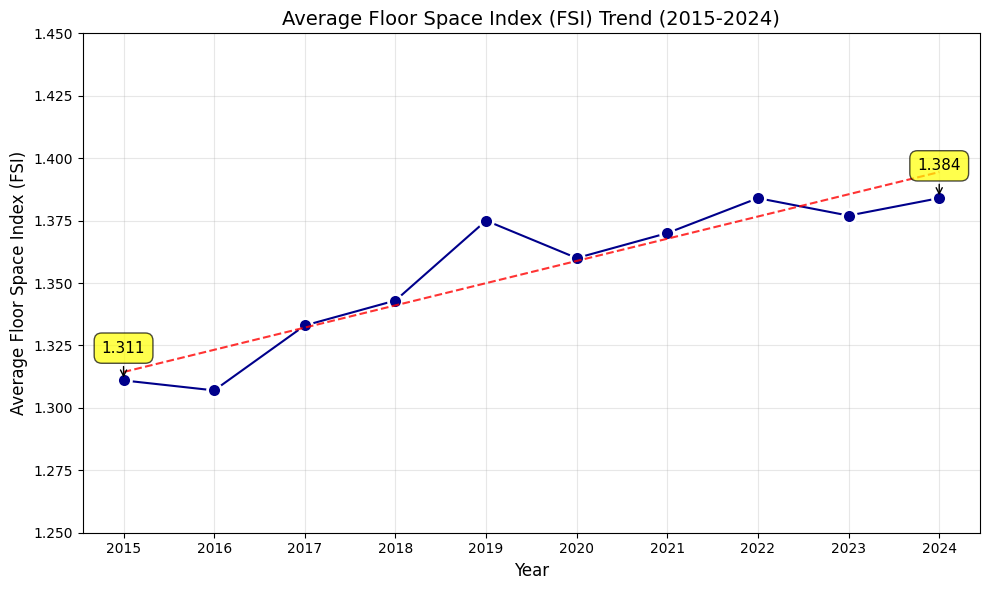


✓ Results saved to 'fsi_analysis.csv'


In [43]:
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob

# ================================================
# FSI (FLOOR SPACE INDEX) TREND ANALYSIS (2015-2024)
# ================================================

# 1. SET YOUR FOLDER PATH HERE!
SHAPEFILE_FOLDER = '/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Final shapefile'

# 2. Find all shapefiles
shapefile_pattern = os.path.join(SHAPEFILE_FOLDER, 'Shapefile_*.shp')
shapefiles = glob.glob(shapefile_pattern)
print(f"Found {len(shapefiles)} shapefiles")

# 3. Process each shapefile
fsi_data = []

for shapefile in sorted(shapefiles):
    filename = os.path.basename(shapefile)
    
    try:
        # Extract year from filename (Shapefile_2024.shp)
        year = int(filename.split('_')[1].split('.')[0])
        
        # Skip if not in 2015-2024 range
        if year < 2015 or year > 2024:
            print(f"⏭ Skipping {filename} (year {year} outside range)")
            continue
        
        # Read shapefile
        print(f"\nProcessing {filename}...")
        gdf = gpd.read_file(shapefile)
        
        # Check if FSI column exists (handle different variations)
        fsi_col = None
        possible_cols = ['FSI', 'fsi', 'Floor Space Index', 'floor_space_index', 'FloorSpaceIndex']
        
        for col in possible_cols:
            if col in gdf.columns:
                fsi_col = col
                break
        
        if fsi_col is None:
            print(f"  ⚠ No FSI column found. Available columns: {list(gdf.columns)}")
            continue
        
        # Get FSI data
        fsi_values = gdf[fsi_col].dropna()
        
        # Calculate statistics
        total_buildings = len(gdf)
        buildings_with_fsi = len(fsi_values)
        avg_fsi = fsi_values.mean()
        median_fsi = fsi_values.median()
        std_fsi = fsi_values.std()
        min_fsi = fsi_values.min()
        max_fsi = fsi_values.max()
        
        # Store results
        fsi_data.append({
            'year': year,
            'total_buildings': total_buildings,
            'buildings_with_fsi': buildings_with_fsi,
            'avg_fsi': avg_fsi,
            'median_fsi': median_fsi,
            'std_fsi': std_fsi,
            'min_fsi': min_fsi,
            'max_fsi': max_fsi
        })
        
        print(f"  ✓ Year {year}: {buildings_with_fsi} buildings")
        print(f"    Average FSI: {avg_fsi:.2f}")
        
    except Exception as e:
        print(f"✗ Error processing {filename}: {e}")

# 4. Create DataFrame and sort by year
df = pd.DataFrame(fsi_data)
df = df.sort_values('year')

# 5. Create the FSI trend plot (same style as volume trend)
if len(df) > 0:
    plt.figure(figsize=(10, 6))
    
    # Main line plot
    plt.plot(df['year'], df['avg_fsi'], 
             color='darkblue', 
             marker='o', 
             markersize=10, 
             linewidth=1.5, 
             markeredgecolor='white', 
             markeredgewidth=2)
    
    # Add trend line
    if len(df) > 1:
        z = np.polyfit(df['year'], df['avg_fsi'], 1)
        p = np.poly1d(z)
        plt.plot(df['year'], p(df['year']), "r--", alpha=0.8, linewidth=1.5, label='Trend')
    
    # Labels and title
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Average FSI', fontsize=12)
    plt.title('Average FSI (Floor Space Index) Trend (2015-2024)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.xticks(range(2015, 2025))
    
    # Add annotations for first and last year
    for i in [0, -1]:
        plt.annotate(f'{df["avg_fsi"].iloc[i]:.2f}',
                    xy=(df['year'].iloc[i], df['avg_fsi'].iloc[i]),
                    xytext=(0, 20),
                    textcoords='offset points',
                    ha='center',
                    fontsize=11,
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    
    plt.tight_layout()
    plt.savefig('fsi_trend.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Calculate changes
    start_fsi = df['avg_fsi'].iloc[0]
    end_fsi = df['avg_fsi'].iloc[-1]
    total_change = end_fsi - start_fsi
    pct_change = (total_change / start_fsi) * 100
    
    # 8. Save results
    df.to_csv('fsi_analysis.csv', index=False)
    print(f"\n✓ Results saved to 'fsi_analysis.csv'")
    
else:
    print("\nNo valid data found for analysis.")



## GSI

Found 10 shapefiles

Processing Shapefile_2015.shp...
  ✓ Year 2015: 3399 buildings
    Average GSI: 0.675

Processing Shapefile_2016.shp...
  ✓ Year 2016: 3399 buildings
    Average GSI: 0.634

Processing Shapefile_2017.shp...
  ✓ Year 2017: 2862 buildings
    Average GSI: 0.627

Processing Shapefile_2018.shp...
  ✓ Year 2018: 2865 buildings
    Average GSI: 0.630

Processing Shapefile_2019.shp...
  ✓ Year 2019: 2387 buildings
    Average GSI: 0.572

Processing Shapefile_2020.shp...
  ✓ Year 2020: 2372 buildings
    Average GSI: 0.537

Processing Shapefile_2021.shp...
  ✓ Year 2021: 2356 buildings
    Average GSI: 0.551

Processing Shapefile_2022.shp...
  ✓ Year 2022: 2370 buildings
    Average GSI: 0.547

Processing Shapefile_2023.shp...
  ✓ Year 2023: 2371 buildings
    Average GSI: 0.543

Processing Shapefile_2024.shp...
  ✓ Year 2024: 2433 buildings
    Average GSI: 0.550


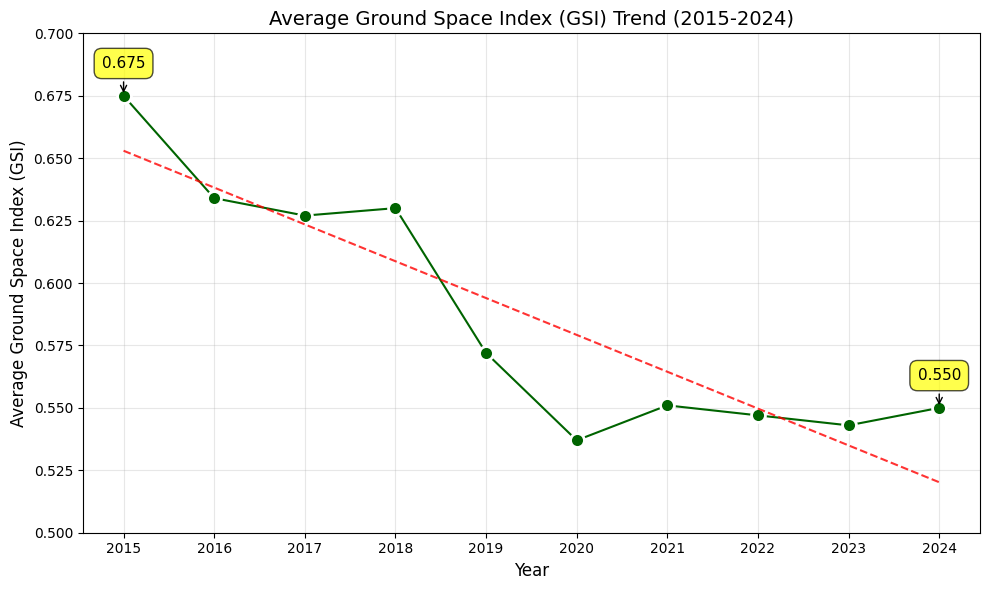


✓ Results saved to 'gsi_analysis.csv'


In [45]:
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob

# ================================================
# GSI (GROUND SPACE INDEX) TREND ANALYSIS (2015-2024)
# ================================================

# 1. SET YOUR FOLDER PATH HERE!
SHAPEFILE_FOLDER = '/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Final shapefile'  # <-- CHANGE THIS!

# 2. Find all shapefiles
shapefile_pattern = os.path.join(SHAPEFILE_FOLDER, 'Shapefile_*.shp')
shapefiles = glob.glob(shapefile_pattern)
print(f"Found {len(shapefiles)} shapefiles")

# 3. Process each shapefile
gsi_data = []

for shapefile in sorted(shapefiles):
    filename = os.path.basename(shapefile)
    
    try:
        # Extract year from filename (Shapefile_2024.shp)
        year = int(filename.split('_')[1].split('.')[0])
        
        # Skip if not in 2015-2024 range
        if year < 2015 or year > 2024:
            print(f"⏭ Skipping {filename} (year {year} outside range)")
            continue
        
        # Read shapefile
        print(f"\nProcessing {filename}...")
        gdf = gpd.read_file(shapefile)
        
        # Check if GSI column exists (handle different variations)
        gsi_col = None
        possible_cols = ['GSI', 'gsi', 'Ground Space Index', 'ground_space_index', 'GroundSpaceIndex']
        
        for col in possible_cols:
            if col in gdf.columns:
                gsi_col = col
                break
        
        if gsi_col is None:
            print(f"  ⚠ No GSI column found. Available columns: {list(gdf.columns)}")
            continue
        
        # Get GSI data
        gsi_values = gdf[gsi_col].dropna()
        
        # Calculate statistics
        total_buildings = len(gdf)
        buildings_with_gsi = len(gsi_values)
        avg_gsi = gsi_values.mean()
        median_gsi = gsi_values.median()
        std_gsi = gsi_values.std()
        min_gsi = gsi_values.min()
        max_gsi = gsi_values.max()
        
        # Store results
        gsi_data.append({
            'year': year,
            'total_buildings': total_buildings,
            'buildings_with_gsi': buildings_with_gsi,
            'avg_gsi': avg_gsi,
            'median_gsi': median_gsi,
            'std_gsi': std_gsi,
            'min_gsi': min_gsi,
            'max_gsi': max_gsi
        })
        
        print(f"  ✓ Year {year}: {buildings_with_gsi} buildings")
        print(f"    Average GSI: {avg_gsi:.2f}")
        
    except Exception as e:
        print(f"✗ Error processing {filename}: {e}")

# 4. Create DataFrame and sort by year
df = pd.DataFrame(gsi_data)
df = df.sort_values('year')

# 5. Create the GSI trend plot (same style as volume trend)
if len(df) > 0:
    plt.figure(figsize=(10, 6))
    
    # Main line plot
    plt.plot(df['year'], df['avg_gsi'], 
             color='darkgreen', 
             marker='o', 
             markersize=10, 
             linewidth=1.5, 
             markeredgecolor='white', 
             markeredgewidth=2)
    
    # Add trend line
    if len(df) > 1:
        z = np.polyfit(df['year'], df['avg_gsi'], 1)
        p = np.poly1d(z)
        plt.plot(df['year'], p(df['year']), "r--", alpha=0.8, linewidth=1.5, label='Trend')
    
    # Labels and title
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Average GSI', fontsize=12)
    plt.title('Average GSI (Ground Space Index) Trend (2015-2024)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.xticks(range(2015, 2025))
    
    # Add annotations for first and last year
    for i in [0, -1]:
        plt.annotate(f'{df["avg_gsi"].iloc[i]:.2f}',
                    xy=(df['year'].iloc[i], df['avg_gsi'].iloc[i]),
                    xytext=(0, 20),
                    textcoords='offset points',
                    ha='center',
                    fontsize=11,
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    
    plt.tight_layout()
    plt.savefig('gsi_trend.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Calculate changes
    start_gsi = df['avg_gsi'].iloc[0]
    end_gsi = df['avg_gsi'].iloc[-1]
    total_change = end_gsi - start_gsi
    pct_change = (total_change / start_gsi) * 100
    
    # 8. Save results
    df.to_csv('gsi_analysis.csv', index=False)
    print(f"\n✓ Results saved to 'gsi_analysis.csv'")
    
else:
    print("\nNo valid data found for analysis.")
    


## Building Ratio

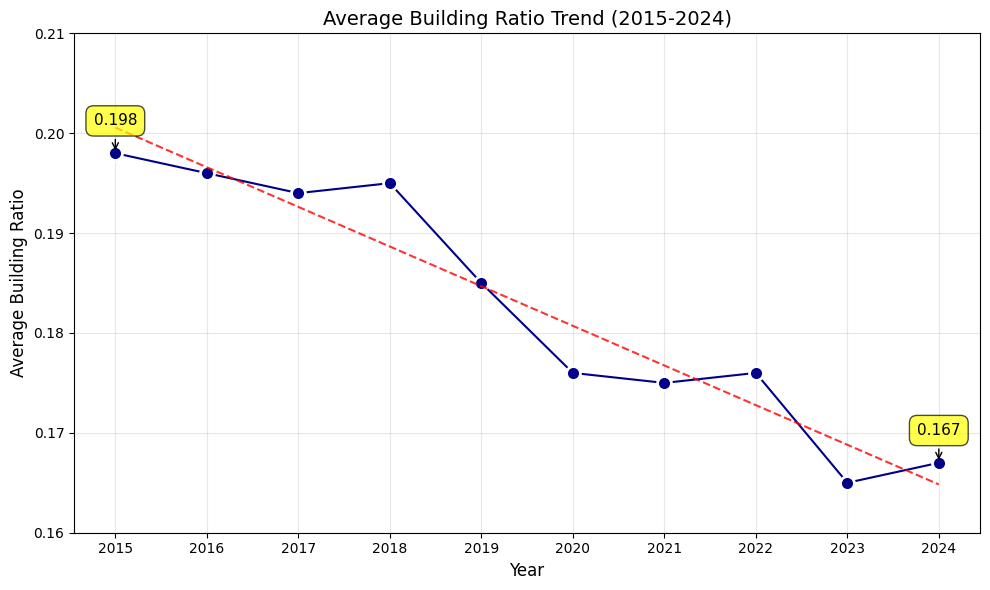

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ================================================
# Building Ratio ANALYSIS (2015-2024)
# ================================================

# Your data
years = list(range(2015, 2025))
building_ratio_values = [0.198, 0.196, 0.194, 0.195, 0.185, 0.176, 0.175, 0.176, 0.165, 0.167]

# Create DataFrame
df = pd.DataFrame({
    'year': years,
    'building_ratio': building_ratio_values,
})

# ================================================
# Building Ratio Trend
# ================================================
plt.figure(figsize=(10, 6))

# Main line plot for FSI
plt.plot(df['year'], df['building_ratio'], 
         color='darkblue', 
         marker='o', 
         markersize=10, 
         linewidth=1.5, 
         markeredgecolor='white', 
         markeredgewidth=2)

# Add trend line
z_fsi = np.polyfit(df['year'], df['building_ratio'], 1)
p_fsi = np.poly1d(z_fsi)
plt.plot(df['year'], p_fsi(df['year']), "r--", alpha=0.8, linewidth=1.5, label='Trend')

# Labels and title
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Building Ratio', fontsize=12)
plt.title('Average Building Ratio Trend (2015-2024)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(range(2015, 2025))
plt.ylim(0.16, 0.21)  # Set appropriate limits for Building Ratio

# Add annotations for first and last year
for i in [0, -1]:
    plt.annotate(f'{df["building_ratio"].iloc[i]:.3f}',
                xy=(df['year'].iloc[i], df['building_ratio'].iloc[i]),
                xytext=(0, 20),
                textcoords='offset points',
                ha='center',
                fontsize=11,
                bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.tight_layout()
plt.savefig('building_ratio_trend.png', dpi=300, bbox_inches='tight')
plt.show()

## Clip into District 3

In [4]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [10]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import shape

def calculate_building_coverage(buildings_path, district_path):
    """
    Calculate the total area of buildings within a district and coverage percentage.
    
    Parameters:
    buildings_path: Path to the buildings shapefile (Shapefile_2015.shp)
    district_path: Path to the district geopackage (District 3.gpkg)
    
    Returns:
    Dictionary with district area, buildings area, and coverage percentage
    """
    
    # Read the shapefiles
    print("Loading buildings shapefile...")
    buildings = gpd.read_file(buildings_path)
    
    print("Loading district geopackage...")
    district = gpd.read_file(district_path)
    
    # Ensure both datasets use the same coordinate reference system (CRS)
    if buildings.crs != district.crs:
        print(f"Reprojecting buildings from {buildings.crs} to {district.crs}")
        buildings = buildings.to_crs(district.crs)
    
    # Check if CRS is projected (for accurate area calculations)
    if district.crs.is_geographic:
        print("Warning: CRS is geographic. Reprojecting to a suitable projected CRS for accurate area calculations...")
        # Use a suitable UTM zone or local projected CRS
        # This example uses Web Mercator, but you should use a local projection for your area
        district = district.to_crs('EPSG:3857')
        buildings = buildings.to_crs('EPSG:3857')
    
    # Perform spatial join to find buildings within the district
    print("Finding buildings within District 3...")
    buildings_in_district = gpd.sjoin(buildings, district, how='inner', predicate='intersects')
    
    # For buildings that partially overlap the district boundary, clip them
    print("Clipping buildings to district boundary...")
    clipped_buildings = []
    
    for idx, building in buildings_in_district.iterrows():
        # Get the corresponding district geometry
        district_geom = district.geometry.iloc[0]  # Assuming single district
        
        # Clip the building to the district boundary
        clipped_geom = building.geometry.intersection(district_geom)
        
        if not clipped_geom.is_empty:
            clipped_buildings.append({
                'geometry': clipped_geom,
                'original_index': idx
            })
    
    # Create a GeoDataFrame from clipped buildings
    clipped_gdf = gpd.GeoDataFrame(clipped_buildings, crs=buildings.crs)
    
    # Calculate areas
    print("\nCalculating areas...")
    
    # Total district area
    district_area = district.geometry.area.sum()
    
    # Total area of buildings within the district
    if len(clipped_gdf) > 0:
        buildings_area = clipped_gdf.geometry.area.sum()
    else:
        buildings_area = 0
    
    # Coverage percentage
    coverage_percentage = (buildings_area / district_area) * 100 if district_area > 0 else 0
    
    # Create results dictionary
    results = {
        'district_area': district_area,
        'buildings_area': buildings_area,
        'coverage_percentage': coverage_percentage,
        'num_buildings': len(clipped_gdf),
        'crs': str(district.crs),
        'crs_units': 'meters' if district.crs.is_projected else 'degrees'
    }
    
    return results, clipped_gdf

def print_results(results):
    """
    Print the analysis results in a formatted way.
    """
    print("\n" + "="*50)
    print("BUILDING COVERAGE ANALYSIS RESULTS")
    print("="*50)
    
    # Determine the unit based on CRS
    unit = "m²" if results['crs_units'] == 'meters' else "square degrees"
    
    print(f"\nCoordinate Reference System: {results['crs']}")
    print(f"\nTotal District 3 Area: {results['district_area']:,.2f} {unit}")
    print(f"Total Buildings Area: {results['buildings_area']:,.2f} {unit}")
    print(f"Number of Buildings: {results['num_buildings']:,}")
    print(f"\nBuilding Coverage: {results['coverage_percentage']:.2f}%")
    
    # Convert to more readable units if in meters
    if results['crs_units'] == 'meters':
        print(f"\nIn other units:")
        print(f"  District Area: {results['district_area']/10000:,.2f} hectares")
        print(f"  District Area: {results['district_area']/1000000:,.2f} km²")
        print(f"  Buildings Area: {results['buildings_area']/10000:,.2f} hectares")
        print(f"  Buildings Area: {results['buildings_area']/1000000:,.2f} km²")

# Main execution
if __name__ == "__main__":
    # Define file paths
    buildings_path = "/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Final shapefile/Shapefile_2015.shp"
    district_path = "/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/10 Years Change/District 3.gpkg"
    
    try:
        # Run the analysis
        results, buildings_in_district = calculate_building_coverage(buildings_path, district_path)
        
        # Print results
        print_results(results)
        
        # Optional: Save the clipped buildings to a new file
        output_path = "buildings_in_district3.gpkg"
        print(f"\nSaving buildings within District 3 to: {output_path}")
        buildings_in_district.to_file(output_path, driver="GPKG")
        
        # Optional: Create a summary report
        summary_df = pd.DataFrame([{
            'District': 'District 3',
            'District Area (m²)': results['district_area'],
            'Buildings Area (m²)': results['buildings_area'],
            'Coverage (%)': results['coverage_percentage'],
            'Number of Buildings': results['num_buildings']
        }])
        
        summary_df.to_csv('district3_building_analysis.csv', index=False)
        print(f"Summary report saved to: district3_building_analysis.csv")
        
    except Exception as e:
        print(f"Error: {e}")
        print("\nTroubleshooting tips:")
        print("1. Ensure both files exist in the specified paths")
        print("2. Check that GeoPandas is installed: pip install geopandas")
        print("3. Verify the shapefile includes all necessary files (.shp, .shx, .dbf, .prj)")

Loading buildings shapefile...
Loading district geopackage...
Reprojecting buildings from EPSG:5174 to EPSG:4326
Finding buildings within District 3...
Clipping buildings to district boundary...
Error: 'NoneType' object has no attribute 'is_empty'

Troubleshooting tips:
1. Ensure both files exist in the specified paths
2. Check that GeoPandas is installed: pip install geopandas
3. Verify the shapefile includes all necessary files (.shp, .shx, .dbf, .prj)


In [12]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import shape
from shapely.validation import make_valid

def fix_geometries(gdf):
    """
    Fix invalid geometries in a GeoDataFrame.
    """
    print("Checking and fixing invalid geometries...")
    
    # Check for invalid geometries
    invalid_mask = ~gdf.geometry.is_valid
    num_invalid = invalid_mask.sum()
    
    if num_invalid > 0:
        print(f"Found {num_invalid} invalid geometries. Attempting to fix...")
        
        # Fix invalid geometries using make_valid
        gdf.loc[invalid_mask, 'geometry'] = gdf.loc[invalid_mask, 'geometry'].apply(
            lambda geom: make_valid(geom) if geom is not None else None
        )
        
        # Remove any None geometries that couldn't be fixed
        gdf = gdf[gdf.geometry.notna()]
        
        # Check again
        still_invalid = (~gdf.geometry.is_valid).sum()
        if still_invalid > 0:
            print(f"Warning: {still_invalid} geometries still invalid after fix attempt.")
        else:
            print("All geometries successfully fixed!")
    else:
        print("All geometries are valid.")
    
    return gdf

def calculate_building_coverage(buildings_path, district_path):
    """
    Calculate the total area of buildings within a district and coverage percentage.
    
    Parameters:
    buildings_path: Path to the buildings shapefile (Shapefile_2015.shp)
    district_path: Path to the district geopackage (District 3.gpkg)
    
    Returns:
    Dictionary with district area, buildings area, and coverage percentage
    """
    
    # Read the shapefiles
    print("Loading buildings shapefile...")
    buildings = gpd.read_file(buildings_path)
    print(f"Loaded {len(buildings)} buildings")
    
    print("\nLoading district geopackage...")
    district = gpd.read_file(district_path)
    print(f"Loaded {len(district)} district(s)")
    
    # Fix any invalid geometries
    buildings = fix_geometries(buildings)
    district = fix_geometries(district)
    
    # Store original CRS info
    original_crs = buildings.crs
    print(f"\nOriginal buildings CRS: {original_crs}")
    print(f"Original district CRS: {district.crs}")
    
    # Since your data is in EPSG:5174 (Korean projected system), keep it!
    # Only reproject if necessary
    if buildings.crs != district.crs:
        # If district is in geographic (4326), reproject it to match buildings
        if district.crs.to_epsg() == 4326 and buildings.crs.to_epsg() == 5174:
            print(f"Reprojecting district to match buildings CRS (EPSG:5174)...")
            district = district.to_crs(buildings.crs)
        else:
            print(f"Reprojecting buildings to match district CRS...")
            buildings = buildings.to_crs(district.crs)
    
    # Perform spatial join to find buildings within the district
    print("\nFinding buildings within District 3...")
    
    # First try a simple within check
    buildings_in_district = buildings[buildings.within(district.unary_union)]
    print(f"Found {len(buildings_in_district)} buildings completely within the district")
    
    # Also find buildings that intersect but aren't completely within
    buildings_intersecting = buildings[buildings.intersects(district.unary_union)]
    print(f"Found {len(buildings_intersecting)} buildings intersecting the district")
    
    # For buildings that intersect, clip them to the district boundary
    print("\nClipping buildings to district boundary...")
    clipped_buildings = []
    
    # Get the district geometry (assuming single district)
    district_geom = district.unary_union
    
    for idx, building in buildings_intersecting.iterrows():
        try:
            # Ensure geometries are valid before intersection
            building_geom = make_valid(building.geometry)
            district_geom_valid = make_valid(district_geom)
            
            # Clip the building to the district boundary
            clipped_geom = building_geom.intersection(district_geom_valid)
            
            if not clipped_geom.is_empty and clipped_geom.area > 0:
                clipped_buildings.append({
                    'geometry': clipped_geom,
                    'original_index': idx,
                    'area': clipped_geom.area
                })
        except Exception as e:
            print(f"Warning: Could not process building at index {idx}: {e}")
            continue
    
    # Create a GeoDataFrame from clipped buildings
    if clipped_buildings:
        clipped_gdf = gpd.GeoDataFrame(clipped_buildings, crs=buildings.crs)
    else:
        clipped_gdf = gpd.GeoDataFrame([], crs=buildings.crs)
    
    print(f"Successfully clipped {len(clipped_gdf)} buildings")
    
    # Calculate areas
    print("\nCalculating areas...")
    
    # Total district area
    district_area = district.geometry.area.sum()
    
    # Total area of buildings within the district
    if len(clipped_gdf) > 0:
        buildings_area = clipped_gdf['area'].sum()
    else:
        buildings_area = 0
    
    # Coverage percentage
    coverage_percentage = (buildings_area / district_area) * 100 if district_area > 0 else 0
    
    # Create results dictionary
    results = {
        'district_area': district_area,
        'buildings_area': buildings_area,
        'coverage_percentage': coverage_percentage,
        'num_buildings': len(clipped_gdf),
        'num_buildings_intersecting': len(buildings_intersecting),
        'crs': str(buildings.crs),
        'crs_units': 'meters' if buildings.crs.is_projected else 'degrees'
    }
    
    return results, clipped_gdf

def print_results(results):
    """
    Print the analysis results in a formatted way.
    """
    print("\n" + "="*50)
    print("BUILDING COVERAGE ANALYSIS RESULTS")
    print("="*50)
    
    # Determine the unit based on CRS
    unit = "m²" if results['crs_units'] == 'meters' else "square degrees"
    
    print(f"\nCoordinate Reference System: {results['crs']}")
    print(f"\nTotal District 3 Area: {results['district_area']:,.2f} {unit}")
    print(f"Total Buildings Area: {results['buildings_area']:,.2f} {unit}")
    print(f"Number of Buildings (clipped): {results['num_buildings']:,}")
    print(f"Number of Buildings (intersecting): {results['num_buildings_intersecting']:,}")
    print(f"\nBuilding Coverage: {results['coverage_percentage']:.2f}%")
    
    # Convert to more readable units if in meters
    if results['crs_units'] == 'meters':
        print(f"\nIn other units:")
        print(f"  District Area: {results['district_area']/10000:,.2f} hectares")
        print(f"  District Area: {results['district_area']/1000000:,.2f} km²")
        print(f"  Buildings Area: {results['buildings_area']/10000:,.2f} hectares")
        print(f"  Buildings Area: {results['buildings_area']/1000000:,.2f} km²")

# Main execution
if __name__ == "__main__":
    # Define file paths
    buildings_path = "/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Final shapefile/Shapefile_2015.shp"
    district_path = "/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/10 Years Change/District 3.gpkg"
    
    try:
        # Run the analysis
        results, buildings_in_district = calculate_building_coverage(buildings_path, district_path)
        
        # Print results
        print_results(results)
        
        # Optional: Save the clipped buildings to a new file
        if len(buildings_in_district) > 0:
            output_path = "buildings_in_district3.gpkg"
            print(f"\nSaving buildings within District 3 to: {output_path}")
            buildings_in_district.to_file(output_path, driver="GPKG")
        
        # Optional: Create a summary report
        summary_df = pd.DataFrame([{
            'District': 'District 3',
            'District Area (m²)': results['district_area'],
            'Buildings Area (m²)': results['buildings_area'],
            'Coverage (%)': results['coverage_percentage'],
            'Number of Buildings': results['num_buildings']
        }])
        
        summary_df.to_csv('district3_building_analysis.csv', index=False)
        print(f"Summary report saved to: district3_building_analysis.csv")
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        print("\nTroubleshooting tips:")
        print("1. Ensure both files exist in the specified paths")
        print("2. Check that GeoPandas is installed: pip install geopandas")
        print("3. Verify the shapefile includes all necessary files (.shp, .shx, .dbf, .prj)")
        print("4. Try updating Shapely: pip install --upgrade shapely")

Loading buildings shapefile...
Loaded 3399 buildings

Loading district geopackage...
Loaded 2 district(s)
Checking and fixing invalid geometries...
All geometries are valid.
Checking and fixing invalid geometries...
Found 1 invalid geometries. Attempting to fix...
All geometries successfully fixed!

Original buildings CRS: EPSG:5174
Original district CRS: EPSG:4326
Reprojecting district to match buildings CRS (EPSG:5174)...

Finding buildings within District 3...
Found 445 buildings completely within the district
Found 494 buildings intersecting the district

Clipping buildings to district boundary...
Successfully clipped 494 buildings

Calculating areas...

BUILDING COVERAGE ANALYSIS RESULTS

Coordinate Reference System: EPSG:5174

Total District 3 Area: 87,468.86 m²
Total Buildings Area: 39,851.17 m²
Number of Buildings (clipped): 494
Number of Buildings (intersecting): 494

Building Coverage: 45.56%

In other units:
  District Area: 8.75 hectares
  District Area: 0.09 km²
  Building

/var/folders/5v/5nwj3q8d66j_03jpgzv73xt40000gn/T/ipykernel_99116/2254749375.py:83: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buildings_in_district = buildings[buildings.within(district.unary_union)]
/var/folders/5v/5nwj3q8d66j_03jpgzv73xt40000gn/T/ipykernel_99116/2254749375.py:87: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buildings_intersecting = buildings[buildings.intersects(district.unary_union)]
/var/folders/5v/5nwj3q8d66j_03jpgzv73xt40000gn/T/ipykernel_99116/2254749375.py:95: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  district_geom = district.unary_union
